In [29]:
%matplotlib inline
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt

import IPython

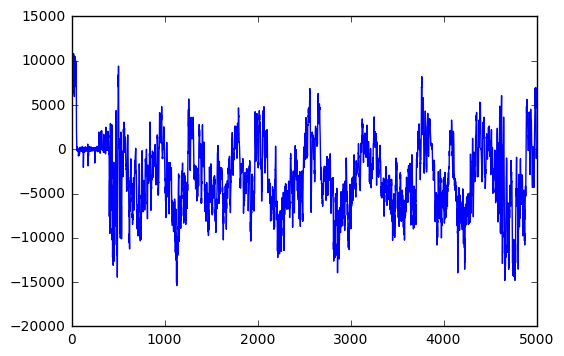

In [104]:
raw_audio = np.fromfile("comercial.raw", np.int16)

plt.plot(raw_audio[:5000])
IPython.display.Audio(raw_audio, rate=32e3)

In [108]:

wavfile.write("comercial2.wav", rate=32000, data=raw_audio)
np.max(raw_audio)

10785

In [30]:
def load_iq(filename):
    x = np.fromfile(filename, np.uint8) + np.int8(-127) #adding a signed int8 to an unsigned one results in an int16 array
    return x.astype(np.int8).reshape((x.size//2, 2))	#we cast it back to an int8 array and reshape

In [31]:
def load_iq_complex(filename):
    x = np.fromfile(filename, np.uint8) - np.float32(127.5) #by subtracting a float32 the resulting array will also be float32
    return 8e-3*x.view(np.complex64)                        #viewing it as a complex64 array then yields the correct result

In [32]:
iq_samples = load_iq_complex('comercial_s2m4_g20.dat')
sample_rate = 2400000

In [ ]:
from rtlsdr import RtlSdr
from contextlib import closing

#we use a context manager that automatically calls .close() on sdr
#whether the code block finishes successfully or an error occurs
with closing(RtlSdr()) as sdr:  
    sdr.sample_rate = sample_rate = 2400000
    sdr.center_freq = 97.4e6
    sdr.gain = 20
    #sdr.freq_correction = 
    #sdr.bandwidth = 200000
    iq_samples = sdr.read_samples(10*sample_rate)

In [33]:
from scipy import signal
from scipy.fftpack import fftshift

f, Pxx = signal.welch(iq_samples, sample_rate, detrend=lambda x: x)
f, Pxx = fftshift(f), fftshift(Pxx)

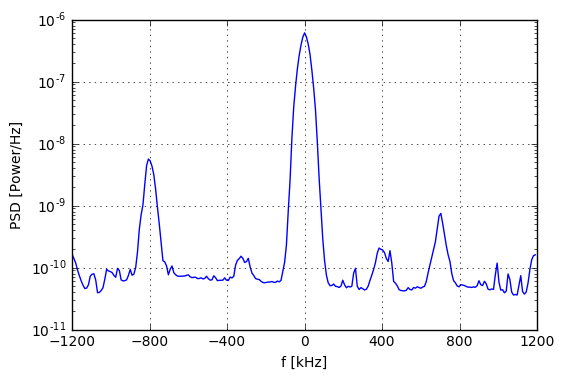

In [34]:
plt.semilogy(f/1e3, Pxx)
plt.xlabel('f [kHz]')
plt.ylabel('PSD [Power/Hz]')
plt.grid()

plt.xticks(np.linspace(-sample_rate/2e3, sample_rate/2e3, 7))
plt.xlim(-sample_rate/2e3, sample_rate/2e3)

plt.gcf().savefig('pwelch_whole.png')

In [79]:
sample_rate_fm = 240000
sample_rate_fm = sample_rate//(sample_rate//sample_rate_fm)

iq_comercial = signal.decimate(iq_samples, sample_rate//sample_rate_fm, zero_phase=True)

f_comercial, Pxx_comercial = signal.welch(iq_comercial, sample_rate_fm, detrend=lambda x: x)
f_comercial, Pxx_comercial = fftshift(f_comercial), fftshift(Pxx_comercial)

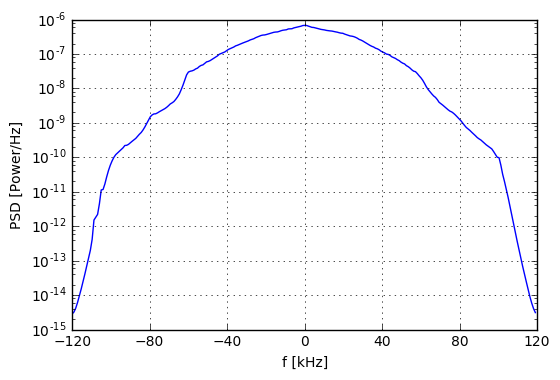

In [81]:
plt.semilogy(f_comercial/1e3, Pxx_comercial)
plt.xlabel('f [kHz]')
plt.ylabel('PSD [Power/Hz]')
plt.grid()

plt.xticks(np.linspace(-sample_rate_fm/2e3, sample_rate_fm/2e3, 7))
plt.xlim(-sample_rate_fm/2e3, sample_rate_fm/2e3)

plt.gcf().savefig('pwelch_comercial.png')

In [122]:
angle_comercial = np.unwrap(np.angle(iq_comercial))
demodulated_comercial = np.diff(angle_comercial)

audio_rate = 48000
audio_comercial = signal.decimate(demodulated_comercial, sample_rate_fm//audio_rate, zero_phase=True)

audio_comercial = np.int16(1e4*audio_comercial)
wavfile.write("../audio/comercial_demodulated.wav", rate=audio_rate, data=audio_comercial)
IPython.display.Audio("../audio/comercial_demodulated.wav", rate=audio_rate)

In [113]:
np.int16(5000*audio_comercial)

array([-766, 1140,  441, ...,  407,  510,  -59], dtype=int16)

## Tuning to a Different Station

The interesting thing about SDR is that once the 

In [125]:
f_shift = 800000
iq_shifted = iq_samples*np.exp(1j*2*np.pi*f_shift/sample_rate*np.arange(len(iq_samples)))

f_shifted, Pxx_shifted = signal.welch(iq_shifted, sample_rate, detrend=lambda x: x)
f_shifted, Pxx_shifted = fftshift(f_shifted), fftshift(Pxx_shifted)

iq_smooth = signal.decimate(iq_shifted, sample_rate//sample_rate_fm, zero_phase=True)

f_smooth, Pxx_smooth = signal.welch(iq_smooth, sample_rate_fm, detrend=lambda x: x)
f_smooth, Pxx_smooth = fftshift(f_smooth), fftshift(Pxx_smooth)

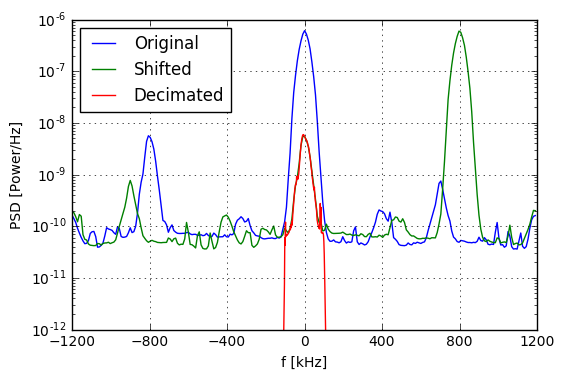

In [124]:
plt.semilogy(f/1e3, Pxx, label='Original')
plt.semilogy(f_shifted/1e3, Pxx_shifted, label='Shifted')
plt.semilogy(f_smooth/1e3, Pxx_smooth, label='Decimated')
plt.xlabel('f [kHz]')
plt.ylabel('PSD [Power/Hz]')
plt.grid()

plt.xticks(np.linspace(-sample_rate/2e3, sample_rate/2e3, 7))
plt.xlim(-sample_rate/2e3, sample_rate/2e3)
plt.ylim(1e-12, 1e-6)

plt.legend(bbox_to_anchor=(0., 1.), loc=2, borderaxespad=0.5)

plt.gcf().savefig('pwelch_smooth.png')

In [128]:
angle_smooth = np.unwrap(np.angle(iq_smooth))
demodulated_smooth = np.diff(angle_smooth)

audio_rate = 48000
audio_smooth = signal.decimate(demodulated_smooth, sample_rate_fm//audio_rate, zero_phase=True)

audio_smooth = np.int16(1e4*audio_smooth)
wavfile.write("../audio/smooth_demodulated.wav", rate=audio_rate, data=audio_smooth)
IPython.display.Audio("../audio/smooth_demodulated.wav", rate=audio_rate)
#IPython.display.Audio(audio_smooth, rate=audio_rate)

In [93]:
from fractions import Fraction
Fraction.from_float(200000/48000)

Fraction(4691249611844267, 1125899906842624)

In [134]:
np.pi*80/120

2.0943951023931953

In [17]:
def shift_and_decimate(x, sample_rate=2400000, bw=200000, f_shift=0):
    if f_shift != 0:
        x = x*np.exp(1j*2*np.pi*f_shift/sample_rate*np.arange(len(x)))
        
    n_dec = sample_rate//bw
    return signal.decimate(x, n_dec), sample_rate//n_dec

In [5]:
def demod_fm(x, rate_in=1020000, rate_out=30000):
    n = rate_in//rate_out
    return signal.decimate(np.diff(np.unwrap(np.arctan2(x[:,1], x[:,0]))), n, ftype='fir')
    
def demod_fm_quad(x, rate_in=1020000, rate_out=30000):
    dx = x[2:] - x[:-2]
    #num = x[1:-1,::-1]*dx
    dphase = x[1:-1,0]*dx[:,1] - x[1:-1,1]*dx[:,0]#(num[:,1]-num[:,0])
    
    n = rate_in//rate_out
    return signal.decimate(dphase, n, ftype='fir')/(2*np.mean(x**2))
    
def demod_fm_complex(x, rate_in=2400000, rate_out=32000):
    if rate_in > 200000:
        n1 = rate_in//200000
        rate_in = rate_in//n1
        x = signal.decimate(x, n1) #decimate to 200 kHz bandwidth
        
    n = rate_in//rate_out
    return signal.decimate(np.diff(np.unwrap(np.angle(x))), n, ftype='fir')
    
def demod_fm_quad_complex(x, rate_in=2400000, rate_out=32000):
    if rate_in > 200000:
        n1 = rate_in//200000
        rate_in = rate_in//n1
        x = signal.decimate(x, n1) #decimate to 200 kHz bandwidth
        
    dx = x[2:] - x[:-2]
    #num = x[1:-1,::-1]*dx
    dphase = x[1:-1,0]*dx[:,1] - x[1:-1,1]*dx[:,0]#(num[:,1]-num[:,0])
    
    n = rate_in//rate_out
    return signal.decimate(dphase, n, ftype='fir')/(2*np.mean(x**2))
#%%

def demod_fm(x, rate_in=200000, rate_out=32000):
    n_dec = rate_in//rate_out
    return signal.decimate(np.diff(np.unwrap(np.angle(x))), n_dec, ftype='fir', zero_phase=True), rate_in//n_dec
